# gw2 1:2 Bifurcation Diagrams

TODO:
fix bifurcation code to use last non-nan initial condition, as opposed to reverting to the original initial condition.

SHOULD I BE USING THE TAYLOR EXPANSION IN PSI OF THE COUPLING TERM IN THE AVERAGED PSI EQUATION??????

I'm trying to figure out why the 1d bifurcation diagram in the full model is "flipped" compared to the reduced model.

It is unclear if it's in how I set up the model equations, or if there is a calculation error.

The homogeneous case works well enough. but with even a tiny bit of heterogeneity, the solutions don't match for small epsilon.

# Inits

In [34]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import gw2

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, 
get_period, bif1d, follow_phase_diffs, phase_lock_r3d, follow_locking_3d,
load_phase_lock_r3d)

from lib.rhs import _redu_c,_full
from lib.rhs import _redu_3dc_gw as _redu_3dc

from lib.plot_util import add_diagram_1d_scatter, quick_plot_combined

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-8,'atol':1e-8,'method':'LSODA'}

In [3]:
pd1 = {'v1':.84,'v2':.42,'v4':.35,'v6':.35,'v8':1,
           'k1':1,'k2':1,'k3':.7,'k4':1,'k5':.7,
           'k6':1,'k7':.35,'k8':1,'K':0.5,'kc':1,
           'n':6,'L':0,'del':0,'om':1,'om_fix':1}

In [4]:
kws1 = {'var_names':['x','y','z','v'],
        'pardict':pd1,
        'rhs':gw2.rhs,
        'coupling':gw2.coupling,
        'init':np.array([.3882,.523,1.357,.4347,24.2]),
        'TN':2000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':False,
        'i_forward':[False,True,False,False,False],
        'i_bad_dx':[False,True,False,False,False],
        'max_iter':20,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':0.5}

## Defs

In [5]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [6]:
eps_list12r = np.linspace(0.001,.1,50)
etup12 = (.001,.1,50)

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

rhs redu 4d

In [8]:
def _redu_4dc(t,y,a,eps=.01,del1=0):
    system1 = a.system1;system2 = a.system2
    pdA = a.system1.pardict;pdB = a.system2.pardict

    s,ds = np.linspace(0,2*np.pi*a._m[1],2000,retstep=True)
    thA,psA,thB,psB = y

    om = a._n[1]/a._m[1]
    in1 = thA-om*thB+om*s;in2 = s

    zA = a.th_lam(in1,psA);iA = a.ps_lam(in1,psA)
    zB = a.th_lam(in2,psB);iB = a.ps_lam(in2,psB)

    # coupling terms
    v1 = system1.lc['lam_v0'](in1) + a.g_lam(in1,psA)
    v2 = system2.lc['lam_v1'](in2) + a.g_lam(in2,psB)

    GA = (pdA['K0']*(v1+v2)/2/pdA['kc0'])*pdA['om_fix0']
    GB = (pdB['K1']*(v2+v1)/2/pdB['kc1'])*pdB['om_fix1']

    dthA = eps*np.sum(zA*GA)*ds/(2*np.pi*a._m[1])
    dpsA = a.system1.kappa_val*psA + eps*np.sum(iA*GA)*ds/(2*np.pi*a._m[1])

    dthB = eps*np.sum(zB*GB)*ds/(2*np.pi*a._m[1])
    dpsB = a.system2.kappa_val*psB + eps*np.sum(iB*GB)*ds/(2*np.pi*a._m[1])
    
    return np.array([om*dthA,om*dpsA,dthB,dpsB])

## Initialize Response Functions

In [9]:
system1 = rsp(idx=0,model_name='gw0',**kws1)
system2 = rsp(idx=1,model_name='gw1',**kws1)

mkdir ./data/gw0/
* Loading LC data...
self.T 6.283185307179586 omfix 3.859018323065443
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975382527
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/gw1/
* Loading LC data...
self.T 6.283185307179586 omfix 3.859018323065443
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975382527
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# del=0.0

In [10]:
del12_p0 = 0
a12_p0 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',1),_m=('om1',2),
                    NH=1000,
                    save_fig=False,
                    del1=del12_p0)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


H functions

In [11]:
# x_temp2 = np.linspace(0,2*np.pi,100)
# y = _redu_c(0,x_temp2,a12_p0,.01)
# fig,axs = plt.subplots(figsize=(6,2))
# axs.plot(x_temp2,y)

## Get Branches Full

In [12]:
kw_p0 = {'a':a12_p0,'del1':del12_p0,'recompute':False,
        'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [13]:
data_p0_list = []

In [14]:
# bot
dat = follow_phase_diffs(init=0,eps_init=0.005,eps_final=0.078,
                         deps=.01,**kw_p0)
data_p0_list.append(dat)

In [15]:
# mid 1f
dat = follow_phase_diffs(init=2.5,eps_init=0.05,eps_final=0.1,
                         deps=.01,**kw_p0)
data_p0_list.append(dat)

In [16]:
# mid 1b
dat = follow_phase_diffs(init=2.5,eps_init=0.05,eps_final=0.035,
                         deps=-.002,**kw_p0)
data_p0_list.append(dat)

## Get Branches 3D

In [17]:
data_r3d_p0_list = []

In [18]:
# find init for this branch
_,init = phase_lock_r3d([1.5,0,0],a12_p0,.05,_redu_3dc)
print(init)

t_diff 1.12791765776687950, Y=[ 1.12791766 -0.09509141 -0.08287027]                                              
[ 1.1279 -0.0951 -0.0829]


In [19]:
# bot 1f
dat = follow_locking_3d(init,a12_p0,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [20]:
# bot 1b
dat = follow_locking_3d(init,a12_p0,(.05,.001,-.005),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [21]:
# find init for this branch
_,init = phase_lock_r3d([2.4,0,0],a12_p0,.05,_redu_3dc)

t_diff 1.12791765776688370, Y=[ 7.41110296 -0.09509141 -0.08287027]                                              


In [22]:
# top 1f
dat = follow_locking_3d(init,a12_p0,(.05,.09,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [23]:
# top 1b
dat = follow_locking_3d(init,a12_p0,(.05,.001,-.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

## Plot

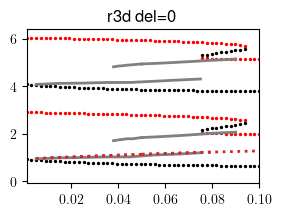

In [24]:
quick_plot_combined(a12_p0,
                    kw_f={'data_list':data_p0_list},
                    kw_r3d={'data_list':data_r3d_p0_list},
                    kw_r={'etup':etup12})

# del=0.0002

In [25]:
del12_p0002 = .0002
a12_p0002 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',1),_m=('om1',2),
                    NH=1000,
                    save_fig=False,
                    del1=1*del12_p0002)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...
* Computing H gw0, order=2...
* Computing H gw1, order=2...
* Computing H gw0, order=3...
* Computing H gw1, order=3...


## Get Branches Full

In [26]:
kw_p0002 = {'a':a12_p0002,'del1':del12_p0002,'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [27]:
data_p0002_list = []

In [28]:
# top 1b
dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.0005,
                         deps=-.0005,**kw_p0002)
data_p0002_list.append(dat)

In [29]:
# top 1f
dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.1,
                         deps=.01,**kw_p0002)
data_p0002_list.append(dat)

In [30]:
# bot 1b
dat = follow_phase_diffs(init=0,eps_init=0.025,eps_final=0.0005,
                         deps=-.005,**kw_p0002)
data_p0002_list.append(dat)

In [31]:
# top 1f
dat = follow_phase_diffs(init=0,eps_init=0.025,eps_final=0.057,
                         deps=.005,**kw_p0002)
data_p0002_list.append(dat)

## Get Branches 3D

In [35]:
data_r3d_p0002_list = []

In [36]:
# find init for this branch
_,init = load_phase_lock_r3d([1.5,0,0],a12_p0002,.05,_redu_3dc,
                            bifdir='gw2_bif1d')
print(init)

t_diff 1.18608002472052320, Y=[ 1.18608002 -0.09817262 -0.08820751]                                              
[ 1.1861 -0.0982 -0.0882]


In [37]:
# bot 1f
dat = follow_locking_3d(init,a12_p0002,(.05,.07,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0002_list.append(dat)

In [38]:
# bot 1b
dat = follow_locking_3d(init,a12_p0002,(.05,.001,-.005),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0002_list.append(dat)

In [39]:
# find init for this branch
_,init = load_phase_lock_r3d([2.4,.1,.1],a12_p0002,.05,_redu_3dc,
                            bifdir='gw2_bif1d')

t_diff 4.26134071454067808, Y=[-14.58821521  -1.43124976  -1.35721309]                                              


In [40]:
# top 1f
dat = follow_locking_3d(init,a12_p0002,(.05,.1,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0002_list.append(dat)

eps iter 0 0.05                
t_diff 4.26134071454055208, Y=[ 4.26134071 -1.43124976 -1.35721309]                                              
eps iter 1 0.060000000000000005                
t_diff 1.220692263191571510, Y=[ 1.22069226 -0.11889116 -0.10855998]                                              
eps iter 2 0.07                
t_diff 1.25123693065309-11, Y=[ 1.25123693 -0.1397285  -0.1293024 ]                                              
eps iter 3 0.08000000000000002                
t_diff 1.27810986768500511, Y=[ 1.27810987 -0.1606648  -0.15031542]                                              
eps iter 4 0.09000000000000001                
t_diff 1.30195758216819462, Y=[ 1.30195758 -0.18169864 -0.17154321]                                              


In [41]:
# top 1b
dat = follow_locking_3d(init,a12_p0002,(.05,.001,-.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0002_list.append(dat)

eps iter 0 0.05                
t_diff 4.26134071454055208, Y=[ 4.26134071 -1.43124976 -1.35721309]                                              
eps iter 1 0.04                
t_diff 4.39863193368517210, Y=[ 4.39863193 -1.48234343 -1.44369571]                                              
eps iter 2 0.03                
t_diff 4.46332840015071110, Y=[ 4.4633284  -1.55786288 -1.53640561]                                              
eps iter 3 0.019999999999999997                
t_diff 4.49745325769444113, Y=[ 4.49745326 -1.67617742 -1.66450531]                                              
eps iter 4 0.009999999999999995                
t_diff 4.51744212015281508, Y=[ 4.51744212 -1.90472577 -1.90064421]                                              


## Plot

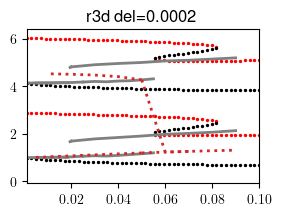

In [42]:
quick_plot_combined(a12_p0002,
                    kw_f={'data_list':data_p0002_list},
                    kw_r3d={'data_list':data_r3d_p0002_list},
                    kw_r={'etup':etup12})

# del=0.0003

In [43]:
del12_p0003 = .0003
a12_p0003 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',1),_m=('om1',2),
                    NH=1000,
                    save_fig=False,
                    del1=1*del12_p0003)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...
* Computing H gw0, order=2...
* Computing H gw1, order=2...
* Computing H gw0, order=3...
* Computing H gw1, order=3...


## Get Branches Full

In [44]:
kw_p0003 = {'a':a12_p0003,'del1':del12_p0003,'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [45]:
data_p0003_list = []

In [46]:
# top 1b
data_p0003_list.append(follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.01,deps=-.0005,**kw_p0003))

In [47]:
# top 1f
data_p0003_list.append(follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.1,deps=.01,**kw_p0003))

In [48]:
# bot 1b
data_p0003_list.append(follow_phase_diffs(init=0,eps_init=0.025,eps_final=0.0005,deps=-.005,**kw_p0003))

In [49]:
# bot 1f
data_p0003_list.append(follow_phase_diffs(init=0,eps_init=0.025,eps_final=0.045,deps=.002,**kw_p0003))

## Get Branches 3D

In [50]:
data_r3d_p0003_list = []

In [51]:
# find init for this branch
_,init = phase_lock_r3d([1.5,0,0],a12_p0003,.05,_redu_3dc)
print(init)

t_diff 1.22065122082395811, Y=[ 1.22065122 -0.09950144 -0.09106974]                                              
[ 1.2207 -0.0995 -0.0911]


In [52]:
# bot 1f
dat = follow_locking_3d(init,a12_p0003,(.05,.07,.01),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0003_list.append(dat)

eps iter 0 0.05                
t_diff 1.22065122082397559, Y=[ 1.22065122 -0.09950144 -0.09106974]                                              
eps iter 1 0.060000000000000005                
t_diff 1.25503854386009480, Y=[ 1.25503854 -0.12025838 -0.11180611]                                              
eps iter 2 0.07                
t_diff 1.28450591448014780, Y=[ 1.28450591 -0.14109595 -0.13282012]                                              


In [53]:
# bot 1b
dat = follow_locking_3d(init,a12_p0003,(.05,.001,-.01),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0003_list.append(dat)

eps iter 0 0.05                
t_diff 1.22065122082397559, Y=[ 1.22065122 -0.09950144 -0.09106974]                                              
eps iter 1 0.04                
t_diff 1.18109884575027710, Y=[ 1.18109885 -0.07885004 -0.07079425]                                              
eps iter 2 0.03                
t_diff 1.13720016773833740, Y=[ 1.13720017 -0.05839835 -0.05126734]                                              
eps iter 3 0.019999999999999997                
t_diff 1.09076057947417531, Y=[ 1.09076058 -0.03831504 -0.03281341]                                              
eps iter 4 0.009999999999999995                
t_diff 1.04385919845709663, Y=[ 1.0438592  -0.01879567 -0.01568498]                                              


In [54]:
# # find init for this branch
# _,init = phase_lock_r3d([2.25,0,0],a12_p0003,.02,_redu_3dc)

In [55]:
# # top 1f
# dat = follow_locking_3d(init,a12_p0003,(.02,.1,.01),
#                         rhs=_redu_3dc,recompute=True)
# data_r3d_p0003_list.append(dat)

In [56]:
# # top 1b
# dat = follow_locking_3d(init,a12_p0003,(.02,.001,-.005),
#                         rhs=_redu_3dc,recompute=True)
# data_r3d_p0003_list.append(dat)

## Plot

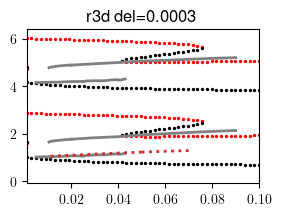

In [57]:
quick_plot_combined(a12_p0003,
                    kw_f={'data_list':data_p0003_list},
                    kw_r3d={'data_list':data_r3d_p0003_list},
                    kw_r={'etup':etup12})

# del=0.0004

In [58]:
del12_p0004 = .0004
a12_p0004 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',1),_m=('om1',2),
                    NH=1000,
                    save_fig=False,
                    del1=1*del12_p0004)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...
* Computing H gw0, order=2...
* Computing H gw1, order=2...
* Computing H gw0, order=3...
* Computing H gw1, order=3...


## Get Branches

In [59]:
kw_p0004 = {'a':a12_p0004,'del1':del12_p0004,'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [60]:
data_p0004_list = []

In [61]:
# top 1b
dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.0005,
                         deps=-.005,**kw_p0004)
data_p0004_list.append(dat)

In [62]:
# top 1f
dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.1,
                         deps=.005,**kw_p0004)
data_p0004_list.append(dat)

In [63]:
# bot 1b
dat = follow_phase_diffs(init=0,eps_init=0.025,eps_final=0.0005,
                         deps=-.005,**kw_p0004)
data_p0004_list.append(dat)

In [64]:
# bot 1f
dat = follow_phase_diffs(init=0,eps_init=0.025,eps_final=0.04,
                         deps=.002,**kw_p0004)
data_p0004_list.append(dat)

## Plot

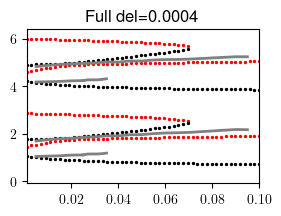

In [66]:
quick_plot_combined(a12_p0004,
                    kw_f={'data_list':data_p0004_list},
                    #kw_r3d={'data_list':data_r3d_p0004_list},
                    kw_r={'etup':etup12})

# del=0.0005

In [67]:
del12_p0005 = .0005
a12_p0005 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',1),_m=('om1',2),
                    NH=1000,
                    save_fig=False,
                    del1=1*del12_p0005)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...
* Computing H gw0, order=2...
* Computing H gw1, order=2...
* Computing H gw0, order=3...
* Computing H gw1, order=3...


## Get Branches Full

In [68]:
kw_p0005 = {'a':a12_p0005,'del1':del12_p0005,'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [69]:
data_p0005_list = []

In [70]:
# top 1b
dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.0005,
                         deps=-.005,**kw_p0005)
data_p0005_list.append(dat)

In [71]:
# top 1f
dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.1,
                         deps=.01,**kw_p0005)
data_p0005_list.append(dat)

In [72]:
# bot 1b
dat = follow_phase_diffs(init=0,eps_init=0.025,eps_final=0.0005,
                         deps=-.005,**kw_p0005)
data_p0005_list.append(dat)

Integrate Reduced Check

In [74]:
# # multiple initial conditions
# init_phases12_p0005 = np.linspace(0,2*np.pi,6,endpoint=False)
# t3d_p0005 = np.arange(0,100000,.01)

# sols_3d = []
# sols_1d = []

# for i in range(len(init_phases12_p0005)):
#     sol3d_p0005 = solve_ivp(_redu_3dc,[0,t3d_p0005[-1]],
#                            [init_phases12_p0005[i],0,0],
#                            args=(a12_p0005,.02),t_eval=t3d_p0005)
    
#     sol1d_p0005 = solve_ivp(_redu_c,[0,t3d_p0005[-1]],
#                            [init_phases12_p0005[i]],
#                            args=(a12_p0005,.02),t_eval=t3d_p0005)
    
#     sols_3d.append(sol3d_p0005)
#     sols_1d.append(sol1d_p0005)

In [75]:
# fig,axs = plt.subplots(figsize=(6,2))
# for i in range(len(init_phases12_p0005)):
#     axs.plot(t3d_p0005,sols_3d[i].y[0],color='blue')
#     axs.plot(t3d_p0005,sols_1d[i].y[0],color='red')
#     print('phase',init_phases12_p0005[i],sols_3d[i].y.T[-1,:])

## Get Branches 3D

In [76]:
data_r3d_p0005_list = []

In [77]:
# find init for this branch
_,init = phase_lock_r3d([1.5,0,0],a12_p0005,.05,_redu_3dc)
print(init)

t_diff 1.31080367408150911, Y=[ 1.31080367 -0.10116297 -0.0972928 ]                                              
[ 1.3108 -0.1012 -0.0973]


In [78]:
# bot 1f
dat = follow_locking_3d(init,a12_p0005,(.05,.1,.01),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0005_list.append(dat)

eps iter 0 0.05                
t_diff 1.31080367408151929, Y=[ 1.31080367 -0.10116297 -0.0972928 ]                                              
eps iter 1 0.060000000000000005                
t_diff 1.33974129154659879, Y=[ 1.33974129 -0.1217189  -0.11843967]                                              
eps iter 2 0.07                
t_diff 1.36245875113170970, Y=[ 1.36245875 -0.14240861 -0.13965692]                                              
eps iter 3 0.08000000000000002                
t_diff 1.38139870238306071, Y=[ 1.3813987  -0.16325911 -0.16098522]                                              
eps iter 4 0.09000000000000001                
t_diff 1.39808072675054213, Y=[ 1.39808073 -0.18427013 -0.18246172]                                              


In [79]:
# bot 1b
dat = follow_locking_3d(init,a12_p0005,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0005_list.append(dat)

eps iter 0 0.05                
t_diff 1.31080367408151929, Y=[ 1.31080367 -0.10116297 -0.0972928 ]                                              
eps iter 1 0.048                
t_diff 1.30398613097675358, Y=[ 1.30398613 -0.09706241 -0.09307019]                                              
eps iter 2 0.046                
t_diff 1.29676146181366053, Y=[ 1.29676146 -0.09296367 -0.08885057]                                              
eps iter 3 0.044                
t_diff 1.28910606342716453, Y=[ 1.28910606 -0.0888659  -0.0846349 ]                                              
eps iter 4 0.041999999999999996                
t_diff 1.28100105196679-13, Y=[ 1.28100105 -0.08476823 -0.08042461]                                              
eps iter 5 0.039999999999999994                
t_diff 1.27243419704413353, Y=[ 1.2724342  -0.08066987 -0.07622171]                                              
eps iter 6 0.03799999999999999                
t_diff 1.26340180515116093, Y=[ 1.26340181

In [80]:
# find init for this branch
_,init = phase_lock_r3d([1.7,0,0], a12_p0005, .02, 
                        _redu_3dc,maxiter=1000)

t_diff 2.85417905586359913, Y=[2.85417906 0.00499567 0.0064882 ]                                                 


In [81]:
# top 1f
dat = follow_locking_3d(init,a12_p0005,(.02,.1,.002),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0005_list.append(dat)

eps iter 0 0.02                
t_diff 2.85417905586359841, Y=[2.85417906 0.00499567 0.0064882 ]                                              
eps iter 1 0.022                
t_diff 2.85402949888397168, Y=[2.8540295  0.00549942 0.00714165]                                              
eps iter 2 0.023999999999999997                
t_diff 2.85387952104983538, Y=[2.85387952 0.00600395 0.00779596]                                              
eps iter 3 0.025999999999999995                
t_diff 2.85372912047212408, Y=[2.85372912 0.00650926 0.00845111]                                              
eps iter 4 0.027999999999999994                
t_diff 2.85357829522441189, Y=[2.8535783  0.00701534 0.00910713]                                              
eps iter 5 0.029999999999999992                
t_diff 2.85342704337092908, Y=[2.85342704 0.0075222  0.00976399]                                              
eps iter 6 0.03199999999999999                
t_diff 2.85327536296566609, Y=

In [82]:
# top 1b
dat = follow_locking_3d(init,a12_p0005,(.02,.001,-.002),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0005_list.append(dat)

eps iter 0 0.02                
t_diff 2.85417905586359841, Y=[2.85417906 0.00499567 0.0064882 ]                                              
eps iter 1 0.018000000000000002                
t_diff 2.85432819385336-08, Y=[2.85432819 0.00449268 0.00583559]                                              
eps iter 2 0.016000000000000004                
t_diff 2.85447691475820438, Y=[2.85447691 0.00399046 0.00518384]                                              
eps iter 3 0.014000000000000005                
t_diff 2.85462522046375808, Y=[2.85462522 0.00348901 0.00453292]                                              
eps iter 4 0.012000000000000007                
t_diff 2.85477311282647738, Y=[2.85477311 0.00298831 0.00388285]                                              
eps iter 5 0.010000000000000009                
t_diff 2.85492059369118408, Y=[2.85492059e+00 2.48837840e-03 3.23362187e-03]                                              
eps iter 6 0.00800000000000001                
t_d

## Plot

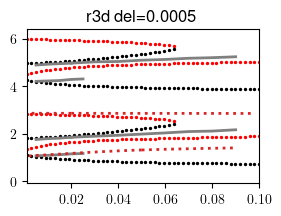

In [83]:
quick_plot_combined(a12_p0005,
                    kw_f={'data_list':data_p0005_list},
                    kw_r3d={'data_list':data_r3d_p0005_list},
                    kw_r={'etup':etup12})

# del=0.00055

In [84]:
del12_p00055 = .00055
a12_p00055 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',1),_m=('om1',2),
                    NH=1000,
                    save_fig=False,
                    del1=1*del12_p00055)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...
* Computing H gw0, order=2...
* Computing H gw1, order=2...
* Computing H gw0, order=3...
* Computing H gw1, order=3...


## Get Branches

In [85]:
kw_p00055 = {'a':a12_p00055,'del1':del12_p00055,'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [86]:
data_p00055_list = []

In [87]:
# top 1b
dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.0005,
                         deps=-.005,**kw_p00055)
data_p00055_list.append(dat)

In [88]:
# top 1f
dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.1,
                         deps=.01,**kw_p00055)
data_p00055_list.append(dat)

In [89]:
# bot 1b
dat = follow_phase_diffs(init=0,eps_init=0.025,eps_final=0.0005,
                         deps=-.005,**kw_p00055)
data_p00055_list.append(dat)

## Plot

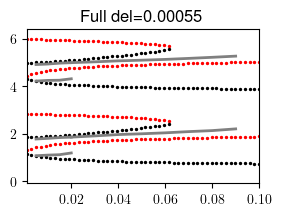

In [90]:
quick_plot_combined(a12_p00055,
                    kw_f={'data_list':data_p00055_list},
                    #kw_r3d={'data_list':data_r3d_p00055_list},
                    kw_r={'etup':etup12})

# del=0.0006

In [91]:
del12_p0006 = .0006
a12_p0006 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',1),_m=('om1',2),
                    NH=1000,
                    save_fig=False,
                    del1=1*del12_p0006)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...
* Computing H gw0, order=2...
* Computing H gw1, order=2...
* Computing H gw0, order=3...
* Computing H gw1, order=3...


## Get Branches

In [92]:
kw_p0006 = {'a':a12_p0006,'del1':del12_p0006,'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [93]:
data_p0006_list = []

In [94]:
dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.0005,
                         deps=-.005,**kw_p0006)
data_p0006_list.append(dat)

In [95]:
dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.1,
                         deps=.01,**kw_p0006)
data_p0006_list.append(dat)

In [96]:
dat = follow_phase_diffs(init=1,eps_init=0.01,eps_final=0.0005,
                         deps=-.005,**kw_p0006)
data_p0006_list.append(dat)

## Plot

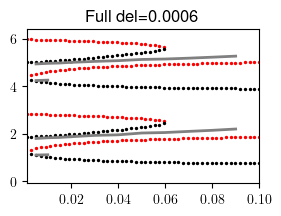

In [97]:
quick_plot_combined(a12_p0006,
                    kw_f={'data_list':data_p0006_list},
                    #kw_r3d={'data_list':data_r3d_p0006_list},
                    kw_r={'etup':etup12})

# del=0.0007

In [98]:
del12_p0007 = .0007
a12_p0007 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',1),_m=('om1',2),
                    NH=1000,
                    save_fig=False,
                    del1=1*del12_p0007)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...
* Computing H gw0, order=2...
* Computing H gw1, order=2...
* Computing H gw0, order=3...
* Computing H gw1, order=3...


## Get Branches Full

In [99]:
kw_p0007 = {'a':a12_p0007,'del1':del12_p0007,'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [100]:
data_p0007_list = []

In [101]:
dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.0005,
                         deps=-.005,**kw_p0007)
data_p0007_list.append(dat)

In [102]:
dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.1,
                         deps=.005,**kw_p0007)
data_p0007_list.append(dat)

In [103]:
dat = follow_phase_diffs(init=1,eps_init=0.005,eps_final=0.0005,
                         deps=-.0005,**kw_p0007)
data_p0007_list.append(dat)

## Get Branches 3D

In [104]:
data_r3d_p0007_list = []

In [105]:
# find init for this branch
_,init = phase_lock_r3d([1,0,0],a12_p0007,.05,_redu_3dc)
print(init)

t_diff 1.47071488850344330, Y=[ 1.47071489 -0.0979121  -0.10323117]                                              
[ 1.4707 -0.0979 -0.1032]


In [106]:
# bot 1f
dat = follow_locking_3d(init,a12_p0007,(.05,.1,.01),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0007_list.append(dat)

eps iter 0 0.05                
t_diff 1.47071488850345070, Y=[ 1.47071489 -0.0979121  -0.10323117]                                              
eps iter 1 0.060000000000000005                
t_diff 1.46064068665088128, Y=[ 1.46064069 -0.11919486 -0.12406088]                                              
eps iter 2 0.07                
t_diff 1.46076280990189210, Y=[ 1.46076281 -0.14033464 -0.14511757]                                              
eps iter 3 0.08000000000000002                
t_diff 1.46501840951410082, Y=[ 1.46501841 -0.16153299 -0.16639482]                                              
eps iter 4 0.09000000000000001                
t_diff 1.47149418475038843, Y=[ 1.47149418 -0.18283396 -0.1878879 ]                                              


In [107]:
# bot 1b
dat = follow_locking_3d(init,a12_p0007,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0007_list.append(dat)

eps iter 0 0.05                
t_diff 1.47071488850345070, Y=[ 1.47071489 -0.0979121  -0.10323117]                                              
eps iter 1 0.048                
t_diff 1.47550369217039214, Y=[ 1.47550369 -0.09357987 -0.09908964]                                              
eps iter 2 0.046                
t_diff 1.48205039346304073, Y=[ 1.48205039 -0.0891883  -0.09495141]                                              
eps iter 3 0.044                
t_diff 1.49107494010444962, Y=[ 1.49107494 -0.08470589 -0.09080857]                                              
eps iter 4 0.041999999999999996                
t_diff 1.50358427446880371, Y=[ 1.50358427 -0.08008636 -0.08664385]                                              
eps iter 5 0.039999999999999994                
t_diff 1.52067562463325110, Y=[ 1.52067562 -0.07527618 -0.08242327]                                              
eps iter 6 0.03799999999999999                
t_diff 1.54260713076261619, Y=[ 1.54260713

In [108]:
# find init for this branch
_,init = phase_lock_r3d([.8,-.01,-.01],a12_p0007,.005,_redu_3dc)

t_diff 1.18372544255194268, Y=[ 1.18372544 -0.01004056 -0.00910742]                                              


In [109]:
# top 1f
dat = follow_locking_3d(init,a12_p0007,(.005,.009,.0005),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0007_list.append(dat)

eps iter 0 0.005                
t_diff 1.18372544255152458, Y=[ 1.18372544 -0.01004056 -0.00910742]                                              
eps iter 1 0.0055                
t_diff 1.18976488175782112, Y=[ 1.18976488 -0.0110527  -0.01006132]                                              
eps iter 2 0.005999999999999999                
t_diff 1.19612419543762382, Y=[ 1.1961242  -0.01206576 -0.01102494]                                              
eps iter 3 0.006499999999999999                
t_diff 1.20288368326623512, Y=[ 1.20288368 -0.01307949 -0.01199928]                                              
eps iter 4 0.006999999999999998                
t_diff 1.21016664100763372, Y=[ 1.21016664 -0.01409355 -0.01298581]                                              
eps iter 5 0.007499999999999998                
t_diff 1.21818094582851751, Y=[ 1.21818095 -0.01510744 -0.01398692]                                              
eps iter 6 0.007999999999999997                
t_diff 1.

In [110]:
# top 1b
dat = follow_locking_3d(init,a12_p0007,(.005,.001,-.001),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0007_list.append(dat)

eps iter 0 0.005                
t_diff 1.18372544255152458, Y=[ 1.18372544 -0.01004056 -0.00910742]                                              
eps iter 1 0.004                
t_diff 1.17239815226454241, Y=[ 1.17239815 -0.00801977 -0.00722606]                                              
eps iter 2 0.003                
t_diff 1.16184845883014452, Y=[ 1.16184846 -0.00600458 -0.00537688]                                              
eps iter 3 0.002                
t_diff 1.15190125325752242, Y=[ 1.15190125 -0.00399581 -0.00355729]                                              


## Plot

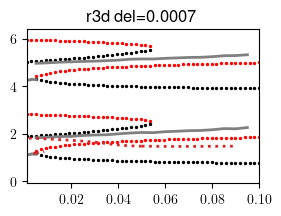

In [111]:
quick_plot_combined(a12_p0007,
                    kw_f={'data_list':data_p0007_list},
                    kw_r3d={'data_list':data_r3d_p0007_list},
                    kw_r={'etup':etup12})